# Guided Project: Predicting House Sale Prices

## 1. EDA and Setting up a pipeline of functions
The data set contains 2930 observations and a large number of explanatory variables (23 nominal, 23 ordinal, 14 discrete, and 20 continuous) involved in assessing home values for the city of Ames, Iowa, United States from 2006 to 2010. 
Variables description
http://jse.amstat.org/v19n3/decock/DataDocumentation.txt

In [1]:
#Import pandas, matplotlib, and numpy into the environment. Import the classes you need from scikit-learn as well.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn import linear_model

In [2]:
#Read AmesHousing.tsv into a pandas data frame.
data=pd.read_csv('AmesHousing.tsv', delimiter="\t")
data.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [3]:
print(data.shape)

(2930, 82)


In [4]:
#Create a function named transform_features() that, for now, just returns the train data frame.
def transform_features(df):
    return df

In [5]:
#Create a function named select_features() that, for now, just returns the Gr Liv Area and SalePrice columns from the train data frame.
def select_features(df):
    return df[['Gr Liv Area','SalePrice']]

In [6]:
#Create a function named train_and_test() that, for now:
def train_and_test(df):
    #Define train and test dataset 50/50
    train=df[:1460]
    test=df[1460:]
    #Select numerical columns
    numeric_columns=train.select_dtypes(include=['float','integer'])
    #Train a model using numerical columns
    features=numeric_columns.columns.drop('SalePrice')
    target='SalePrice'
    lr=LinearRegression()
    lr.fit(train[features],train[target])
    prediction=lr.predict(test[features])
    mse=mean_squared_error(prediction,test[target])
    rmse=np.sqrt(mse)
    return rmse
    

In [7]:
#FIRST RMSE RUN
transformed=transform_features(data)
selected_features=select_features(transformed)
trained_and_tested=train_and_test(selected_features)
print('FIRST RMSE:')
print(trained_and_tested)

FIRST RMSE:
57088.25161263909


## 2. Feature Engineering
Let's now start to removing features with many missing values, diving deeper into potential categorical features, and transforming text and numerical columns. Update transform_features() so that any column from the data frame with more than 25% (or another cutoff value) missing values is dropped. You also need to remove any columns that leak information about the sale (e.g. like the year the sale happened). In general, the goal of this function is to:

remove features that we don't want to use in the model, just based on the number of missing values or data leakage
transform features into the proper format (numerical to categorical, scaling numerical, filling in missing values, etc)
create new features by combining other features
Next, you need to get more familiar with the remaining columns by reading the data documentation for each column, determining what transformations are necessary (if any), and more. As we mentioned earlier, succeeding in predictive modeling (and competitions like Kaggle) is highly dependent on the quality of features the model has. Libraries like scikit-learn has made it quick and easy to simply try and tweak many different models, but cleaning, selecting, and transforming features is still more of an art that requires a bit of human ingenuity.

Handle missing values:
<li>All columns:
Drop any with 5% or more missing values for now.
<li>Text columns:
Drop any with 1 or more missing values for now.
<li>Numerical columns:
For columns with missing values, fill in with the most common value in that column

All columns: Drop any with 5% or more missing values for now.

In [8]:
#Explore all columns with missing values
all_columns=data.isnull().sum().sort_values()

In [9]:
#Show columns with missing value
columns_missing_data=all_columns[all_columns>0]
columns_missing_data

Electrical           1
BsmtFin SF 1         1
BsmtFin SF 2         1
Bsmt Unf SF          1
Total Bsmt SF        1
Garage Cars          1
Garage Area          1
Bsmt Half Bath       2
Bsmt Full Bath       2
Mas Vnr Area        23
Mas Vnr Type        23
Bsmt Qual           80
Bsmt Cond           80
BsmtFin Type 1      80
BsmtFin Type 2      81
Bsmt Exposure       83
Garage Type        157
Garage Finish      159
Garage Cond        159
Garage Yr Blt      159
Garage Qual        159
Lot Frontage       490
Fireplace Qu      1422
Fence             2358
Alley             2732
Misc Feature      2824
Pool QC           2917
dtype: int64

In [10]:
#Show columns with more than 5% missing value
five_percent=data.shape[0]/20
columns_missing_5_data=all_columns[all_columns>five_percent]
columns_missing_5_data

Garage Type       157
Garage Finish     159
Garage Cond       159
Garage Yr Blt     159
Garage Qual       159
Lot Frontage      490
Fireplace Qu     1422
Fence            2358
Alley            2732
Misc Feature     2824
Pool QC          2917
dtype: int64

In [11]:
#All columns: Drop any with 5% or more missing values for now.
print(data.shape)
data=data.drop(columns_missing_5_data.index,axis=1)
print(data.shape)

(2930, 82)
(2930, 71)


In [12]:
#Text columns: Drop any with 1 or more missing values for now.
text_data=data.select_dtypes(include=['object'])
text_columns=text_data.isnull().sum().sort_values()
text_columns_missing_value=text_columns[text_columns>0]
text_columns_missing_value

Electrical         1
Mas Vnr Type      23
Bsmt Cond         80
Bsmt Qual         80
BsmtFin Type 1    80
BsmtFin Type 2    81
Bsmt Exposure     83
dtype: int64

In [13]:
print(data.shape)
data=data.drop(text_columns_missing_value.index,axis=1)
print(data.shape)

(2930, 71)
(2930, 64)


In [14]:
data.head()

,Order,PID,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,...,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,31770,Pave,IR1,Lvl,AllPub,Corner,...,0,0,0,0,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,11622,Pave,Reg,Lvl,AllPub,Inside,...,0,0,120,0,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,14267,Pave,IR1,Lvl,AllPub,Corner,...,0,0,0,0,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,11160,Pave,Reg,Lvl,AllPub,Corner,...,0,0,0,0,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,13830,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,0,3,2010,WD,Normal,189900


Numerical columns: For columns with missing values, fill in with the most common value in that column

In [15]:
numerical_data=data.select_dtypes(['integer','float'])
numerical_missing_value=numerical_data.isnull().sum().sort_values()
numerical_missing_value_columns=numerical_missing_value[numerical_missing_value>0]
numerical_missing_value_columns

Garage Area        1
BsmtFin SF 2       1
Bsmt Unf SF        1
Total Bsmt SF      1
BsmtFin SF 1       1
Garage Cars        1
Bsmt Full Bath     2
Bsmt Half Bath     2
Mas Vnr Area      23
dtype: int64

In [16]:
#This method is not working
#data=data.fillna(data.mode())

In [17]:
# Compute the most common value for each column in `numerical_missing_value_columns`.
replacement_values_dict = data[numerical_missing_value_columns.index].mode().to_dict(orient='records')[0]
replacement_values_dict

{'Bsmt Full Bath': 0.0,
 'Bsmt Half Bath': 0.0,
 'Bsmt Unf SF': 0.0,
 'BsmtFin SF 1': 0.0,
 'BsmtFin SF 2': 0.0,
 'Garage Area': 0.0,
 'Garage Cars': 2.0,
 'Mas Vnr Area': 0.0,
 'Total Bsmt SF': 0.0}

In [18]:
# Use `pd.DataFrame.fillna()` to replace missing values.
data=data.fillna(replacement_values_dict)

In [19]:
# Check missing values
data.isnull().sum().sort_values()

Order              0
Central Air        0
1st Flr SF         0
2nd Flr SF         0
Low Qual Fin SF    0
Gr Liv Area        0
Bsmt Full Bath     0
Bsmt Half Bath     0
Full Bath          0
Half Bath          0
Bedroom AbvGr      0
Kitchen AbvGr      0
Kitchen Qual       0
TotRms AbvGrd      0
Heating QC         0
Functional         0
Garage Cars        0
Garage Area        0
Paved Drive        0
Wood Deck SF       0
Open Porch SF      0
Enclosed Porch     0
3Ssn Porch         0
Screen Porch       0
Pool Area          0
Misc Val           0
Mo Sold            0
Yr Sold            0
Sale Type          0
Fireplaces         0
                  ..
MS SubClass        0
MS Zoning          0
Lot Area           0
Street             0
Lot Shape          0
Land Contour       0
Utilities          0
Lot Config         0
Land Slope         0
Neighborhood       0
Condition 1        0
Condition 2        0
Bldg Type          0
House Style        0
Overall Qual       0
Overall Cond       0
Year Built   

In [20]:
data.isnull().sum().value_counts()

0    64
dtype: int64

In [21]:
#What new features can we create, that better capture the information in some of the features?
columns_seta=data.columns[:20]
columns_setb=data.columns[20:40]
columns_setc=data.columns[40:60]

In [22]:
data[columns_seta]

,Order,PID,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add
0,1,526301100,20,RL,31770,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960
1,2,526350040,20,RH,11622,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961
2,3,526351010,20,RL,14267,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958
3,4,526353030,20,RL,11160,Pave,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968
4,5,527105010,60,RL,13830,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998
5,6,527105030,60,RL,9978,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998
6,7,527127150,120,RL,4920,Pave,Reg,Lvl,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,2001,2001
7,8,527145080,120,RL,5005,Pave,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992
8,9,527146030,120,RL,5389,Pave,IR1,Lvl,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1995,1996
9,10,527162130,60,RL,7500,Pave,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,7,5,1999,1999


In [23]:
data[columns_setb]

,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath
0,Hip,CompShg,BrkFace,Plywood,112.0,TA,TA,CBlock,639.0,0.0,441.0,1080.0,GasA,Fa,Y,1656,0,0,1656,1.0
1,Gable,CompShg,VinylSd,VinylSd,0.0,TA,TA,CBlock,468.0,144.0,270.0,882.0,GasA,TA,Y,896,0,0,896,0.0
2,Hip,CompShg,Wd Sdng,Wd Sdng,108.0,TA,TA,CBlock,923.0,0.0,406.0,1329.0,GasA,TA,Y,1329,0,0,1329,0.0
3,Hip,CompShg,BrkFace,BrkFace,0.0,Gd,TA,CBlock,1065.0,0.0,1045.0,2110.0,GasA,Ex,Y,2110,0,0,2110,1.0
4,Gable,CompShg,VinylSd,VinylSd,0.0,TA,TA,PConc,791.0,0.0,137.0,928.0,GasA,Gd,Y,928,701,0,1629,0.0
5,Gable,CompShg,VinylSd,VinylSd,20.0,TA,TA,PConc,602.0,0.0,324.0,926.0,GasA,Ex,Y,926,678,0,1604,0.0
6,Gable,CompShg,CemntBd,CmentBd,0.0,Gd,TA,PConc,616.0,0.0,722.0,1338.0,GasA,Ex,Y,1338,0,0,1338,1.0
7,Gable,CompShg,HdBoard,HdBoard,0.0,Gd,TA,PConc,263.0,0.0,1017.0,1280.0,GasA,Ex,Y,1280,0,0,1280,0.0
8,Gable,CompShg,CemntBd,CmentBd,0.0,Gd,TA,PConc,1180.0,0.0,415.0,1595.0,GasA,Ex,Y,1616,0,0,1616,1.0
9,Gable,CompShg,VinylSd,VinylSd,0.0,TA,TA,PConc,0.0,0.0,994.0,994.0,GasA,Gd,Y,1028,776,0,1804,0.0


In [24]:
data[columns_setc]

,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Garage Cars,Garage Area,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold
0,0.0,1,0,3,1,TA,7,Typ,2,2.0,528.0,P,210,62,0,0,0,0,0,5
1,0.0,1,0,2,1,TA,5,Typ,0,1.0,730.0,Y,140,0,0,0,120,0,0,6
2,0.0,1,1,3,1,Gd,6,Typ,0,1.0,312.0,Y,393,36,0,0,0,0,12500,6
3,0.0,2,1,3,1,Ex,8,Typ,2,2.0,522.0,Y,0,0,0,0,0,0,0,4
4,0.0,2,1,3,1,TA,6,Typ,1,2.0,482.0,Y,212,34,0,0,0,0,0,3
5,0.0,2,1,3,1,Gd,7,Typ,1,2.0,470.0,Y,360,36,0,0,0,0,0,6
6,0.0,2,0,2,1,Gd,6,Typ,0,2.0,582.0,Y,0,0,170,0,0,0,0,4
7,0.0,2,0,2,1,Gd,5,Typ,0,2.0,506.0,Y,0,82,0,0,144,0,0,1
8,0.0,2,0,2,1,Gd,5,Typ,1,2.0,608.0,Y,237,152,0,0,0,0,0,3
9,0.0,2,1,3,1,Gd,7,Typ,1,2.0,442.0,Y,140,60,0,0,0,0,0,6


In [25]:
years_sold_since_build = data['Yr Sold'] - data['Year Built']
years_sold_since_build[years_sold_since_build < 0]

2180   -1
dtype: int64

In [26]:
years_sold_since_remod = data['Yr Sold'] - data['Year Remod/Add']
years_sold_since_remod[years_sold_since_remod < 0]

1702   -1
2180   -2
2181   -1
dtype: int64

In [27]:
# Create new columns
data['years_sold_since_build']=years_sold_since_build
data['years_sold_since_remod']=years_sold_since_remod

# Drop rows with negative values for both of these new features
data = data.drop([1702,2180,2181],axis=0)

# No longer need original year columns
data = data.drop(['Year Built','Year Remod/Add'],axis=1)

<b>Drop columns that:</b>

<b>that aren't useful for ML</b>
<li>Order (Discrete): Observation number
<li>PID (Nominal): Parcel identification number  - can be used with city web site for parcel review.


<b>leak data about the final sale, read more about columns here</b>

<li>Mo Sold (Discrete): Month Sold (MM)

<li>Sale Condition (Nominal): Condition of sale

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)

<li>Sale Type (Nominal): Type of sale
		
       WD 	Warranty Deed - Conventional
       CWD	Warranty Deed - Cash
       VWD	Warranty Deed - VA Loan
       New	Home just constructed and sold
       COD	Court Officer Deed/Estate
       Con	Contract 15% Down payment regular terms
       ConLw	Contract Low Down payment and low interest
       ConLI	Contract Low Interest
       ConLD	Contract Low Down
       Oth	Other
       
<li>Yr Sold (Discrete): Year Sold (YYYY)

In [28]:
## Drop columns that aren't useful for Machine Learnig (ML)
data = data.drop(["PID", "Order"], axis=1)

## Drop columns that leak info about the final sale
data = data.drop(["Mo Sold", "Sale Condition", "Sale Type", "Yr Sold"], axis=1)

data.shape

(2927, 58)

Update transform_features()

In [29]:
def transform_features(data):
    #Explore all columns with missing values
    all_columns=data.isnull().sum().sort_values()
    #Show columns with missing value
    columns_missing_data=all_columns[all_columns>0]
    #Show columns with more than 5% missing value
    five_percent=data.shape[0]/20
    columns_missing_5_data=all_columns[all_columns>five_percent]
    #All columns: Drop any with 5% or more missing values for now.
    data=data.drop(columns_missing_5_data.index,axis=1)

    #Text columns: Drop any with 1 or more missing values for now.
    text_data=data.select_dtypes(include=['object'])
    text_columns=text_data.isnull().sum().sort_values()
    text_columns_missing_value=text_columns[text_columns>0]
    data=data.drop(text_columns_missing_value.index,axis=1)

    #Numerical columns: For columns with missing values, fill in with the most common value in that column
    numerical_data=data.select_dtypes(['integer','float'])
    numerical_missing_value=numerical_data.isnull().sum().sort_values()
    numerical_missing_value_columns=numerical_missing_value[numerical_missing_value>0]
    # Compute the most common value for each column in `numerical_missing_value_columns`.
    replacement_values_dict = data[numerical_missing_value_columns.index].mode().to_dict(orient='records')[0]
    # Use `pd.DataFrame.fillna()` to replace missing values.
    data=data.fillna(replacement_values_dict)

    # Create new columns
    years_sold_since_build = data['Yr Sold'] - data['Year Built']
    ##years_sold_since_build[years_sold_since_build < 0]
    years_sold_since_remod = data['Yr Sold'] - data['Year Remod/Add']
    ##years_sold_since_remod[years_sold_since_remod < 0]
    data['years_sold_since_build']=years_sold_since_build
    data['years_sold_since_remod']=years_sold_since_remod
    # Drop rows with negative values for both of these new features
    data=data.drop([1702,2180,2181],axis=0)

    # No longer need original year columns
    data = data.drop(['Year Built','Year Remod/Add'],axis=1)
    ## Drop columns that aren't useful for Machine Learnig (ML)
    data = data.drop(["PID", "Order"], axis=1)
    ## Drop columns that leak info about the final sale
    data = data.drop(["Mo Sold", "Sale Condition", "Sale Type", "Yr Sold"], axis=1)
    return data

#Create a function named select_features() that, for now, just returns the Gr Liv Area and SalePrice columns from the train data frame.
def select_features(df):
    return df[['Gr Liv Area','SalePrice']]

#Create a function named train_and_test() that, for now:
def train_and_test(df):
    #Define train and test dataset 50/50
    train=df[:1460]
    test=df[1460:]
    #Select numerical columns
    numeric_columns=train.select_dtypes(include=['float','integer'])
    #Train a model using numerical columns
    features=numeric_columns.columns.drop('SalePrice')
    target='SalePrice'
    lr=LinearRegression()
    lr.fit(train[features],train[target])
    prediction=lr.predict(test[features])
    mse=mean_squared_error(prediction,test[target])
    rmse=np.sqrt(mse)
    return rmse

In [30]:
#SECOND RMSE RUN
data=pd.read_csv('AmesHousing.tsv', delimiter="\t")

transformed=transform_features(data)
selected_features=select_features(transformed)
trained_and_tested=train_and_test(selected_features)
print('SECOND RMSE:')
print(trained_and_tested)

SECOND RMSE:
55275.36731241307


# 3. Feature Selection

In [31]:
#Generate a correlation heatmap matrix of the numerical features in the training data set.
import seaborn as sns
#Select numerical columns
numerical_df=transformed.select_dtypes(include=['integer','float'])
numerical_df

,MS SubClass,Lot Area,Overall Qual,Overall Cond,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,...,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,SalePrice,years_sold_since_build,years_sold_since_remod
0,20,31770,6,5,112.0,639.0,0.0,441.0,1080.0,1656,...,210,62,0,0,0,0,0,215000,50,50
1,20,11622,5,6,0.0,468.0,144.0,270.0,882.0,896,...,140,0,0,0,120,0,0,105000,49,49
2,20,14267,6,6,108.0,923.0,0.0,406.0,1329.0,1329,...,393,36,0,0,0,0,12500,172000,52,52
3,20,11160,7,5,0.0,1065.0,0.0,1045.0,2110.0,2110,...,0,0,0,0,0,0,0,244000,42,42
4,60,13830,5,5,0.0,791.0,0.0,137.0,928.0,928,...,212,34,0,0,0,0,0,189900,13,12
5,60,9978,6,6,20.0,602.0,0.0,324.0,926.0,926,...,360,36,0,0,0,0,0,195500,12,12
6,120,4920,8,5,0.0,616.0,0.0,722.0,1338.0,1338,...,0,0,170,0,0,0,0,213500,9,9
7,120,5005,8,5,0.0,263.0,0.0,1017.0,1280.0,1280,...,0,82,0,0,144,0,0,191500,18,18
8,120,5389,8,5,0.0,1180.0,0.0,415.0,1595.0,1616,...,237,152,0,0,0,0,0,236500,15,14
9,60,7500,7,5,0.0,0.0,0.0,994.0,994.0,1028,...,140,60,0,0,0,0,0,189000,11,11


In [32]:
#Calculate the correlation coefficients for the columns that seem to correlate well with SalePrice.
corr_matrix=numerical_df.corr()
corr_saleprice=corr_matrix['SalePrice'].abs().sort_values()
corr_saleprice

BsmtFin SF 2              0.006127
Misc Val                  0.019273
3Ssn Porch                0.032268
Bsmt Half Bath            0.035875
Low Qual Fin SF           0.037629
Pool Area                 0.068438
MS SubClass               0.085128
Overall Cond              0.101540
Screen Porch              0.112280
Kitchen AbvGr             0.119760
Enclosed Porch            0.128685
Bedroom AbvGr             0.143916
Bsmt Unf SF               0.182751
Lot Area                  0.267520
2nd Flr SF                0.269601
Bsmt Full Bath            0.276258
Half Bath                 0.284871
Open Porch SF             0.316262
Wood Deck SF              0.328183
BsmtFin SF 1              0.439284
Fireplaces                0.474831
TotRms AbvGrd             0.498574
Mas Vnr Area              0.506983
years_sold_since_remod    0.534985
Full Bath                 0.546118
years_sold_since_build    0.558979
1st Flr SF                0.635185
Garage Area               0.641425
Total Bsmt SF       

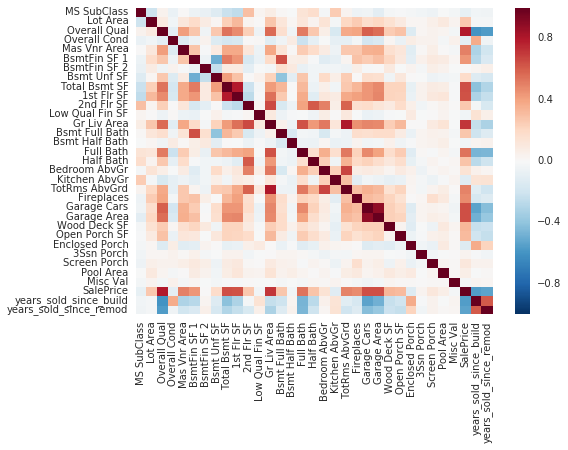

In [33]:
sns.heatmap(corr_matrix)

In [34]:
#Let's only keep columns with a correlation coefficient of larger than 0.4 (arbitrary, worth experimenting later!)
corr_saleprice_40=corr_saleprice[corr_saleprice>0.4]
corr_saleprice_40

BsmtFin SF 1              0.439284
Fireplaces                0.474831
TotRms AbvGrd             0.498574
Mas Vnr Area              0.506983
years_sold_since_remod    0.534985
Full Bath                 0.546118
years_sold_since_build    0.558979
1st Flr SF                0.635185
Garage Area               0.641425
Total Bsmt SF             0.644012
Garage Cars               0.648361
Gr Liv Area               0.717596
Overall Qual              0.801206
SalePrice                 1.000000
Name: SalePrice, dtype: float64

In [35]:
# Drop transformed columns with less than 0.4 correlation with SalePrice
drop_columns=corr_saleprice[corr_saleprice<0.4]
print(transformed.shape)
transformed=transformed.drop(drop_columns.index,axis=1)
print(transformed.shape)

(2927, 58)
(2927, 39)


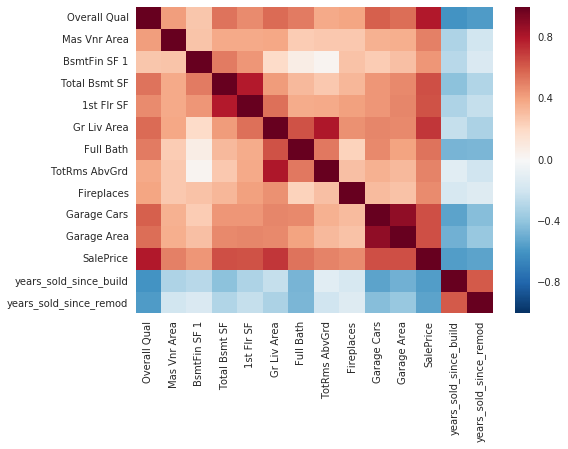

In [36]:
sns.heatmap(transformed.corr())

#Which features correlate strongly with our target column, SalePrice?
1st Flr SF                0.635185
Garage Area               0.641425
Total Bsmt SF             0.644012
Garage Cars               0.648361
Gr Liv Area               0.717596
Overall Qual              0.801206

1st Flr SF (Continuous): First Floor square feet
Garage Area (Continuous): Size of garage in square feet
Total Bsmt SF (Continuous): Total square feet of basement area
Garage Cars (Discrete): Size of garage in car capacity
Gr Liv Area (Continuous): Above grade (ground) living area square feet
Overall Qual (Ordinal): Rates the overall material and finish of the house

Which categorical columns should we keep?

In [37]:
## Create a list of column names from documentation that are *meant* to be categorical
nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", "Misc Feature", "Sale Type", "Sale Condition"]

<li>Which columns are currently numerical but need to be encoded as categorical instead (because the numbers don't have any semantic meaning)?
<li>If a categorical column has hundreds of unique values (or categories), should we keep it? When we dummy code this column, hundreds of columns will need to be added back to the data frame.

In [38]:
# Count unique values per text column of transformed dataset
text_columns=transformed.select_dtypes('object').columns.sort_values()
for i in text_columns:
    print(i+':',len(transformed[i].unique()))

Bldg Type: 5
Central Air: 2
Condition 1: 9
Condition 2: 8
Exter Cond: 5
Exter Qual: 4
Exterior 1st: 16
Exterior 2nd: 17
Foundation: 6
Functional: 8
Heating: 6
Heating QC: 5
House Style: 8
Kitchen Qual: 5
Land Contour: 4
Land Slope: 3
Lot Config: 5
Lot Shape: 4
MS Zoning: 7
Neighborhood: 28
Paved Drive: 3
Roof Matl: 8
Roof Style: 6
Street: 2
Utilities: 3


In [39]:
# Which categorical columns have we still carried with us? We'll test these 
categorical_columns_transformed=[]
for i in nominal_features:
    if i in transformed.columns:
        categorical_columns_transformed.append(i)
# How many unique values in each categorical column? METHOD 1
for i in categorical_columns_transformed:
    print(i+':',len(transformed[i].unique()))

MS Zoning: 7
Street: 2
Land Contour: 4
Lot Config: 5
Neighborhood: 28
Condition 1: 9
Condition 2: 8
Bldg Type: 5
House Style: 8
Roof Style: 6
Roof Matl: 8
Exterior 1st: 16
Exterior 2nd: 17
Foundation: 6
Heating: 6
Central Air: 2


In [40]:
## How many unique values in each categorical column? METHOD 2
uniqueness_counts = transformed[categorical_columns_transformed].apply(lambda col: len(col.value_counts())).sort_values()
uniqueness_counts

Street           2
Central Air      2
Land Contour     4
Lot Config       5
Bldg Type        5
Roof Style       6
Foundation       6
Heating          6
MS Zoning        7
Condition 2      8
House Style      8
Roof Matl        8
Condition 1      9
Exterior 1st    16
Exterior 2nd    17
Neighborhood    28
dtype: int64

In [41]:
# Aribtrary cutoff of 10 unique values (worth experimenting)
drop_unique_values=uniqueness_counts[uniqueness_counts>10].index
transformed=transformed.drop(drop_unique_values,axis=1)

In [42]:
## Select just the remaining text columns and convert to categorical
transformed_text_columns=transformed.select_dtypes(include=['object'])
for i in transformed_text_columns:
    transformed[i]=transformed[i].astype('category')


In [43]:
# Create dummy columns and add back to the dataframe!
transformed = pd.concat([transformed,pd.get_dummies(transformed.select_dtypes(include=['category']))], axis=1)

#Update select_features()

In [44]:
def transform_features(data):
    #Explore all columns with missing values
    all_columns=data.isnull().sum().sort_values()
    #Show columns with missing value
    columns_missing_data=all_columns[all_columns>0]
    #Show columns with more than 5% missing value
    five_percent=data.shape[0]/20
    columns_missing_5_data=all_columns[all_columns>five_percent]
    #All columns: Drop any with 5% or more missing values for now.
    data=data.drop(columns_missing_5_data.index,axis=1)

    #Text columns: Drop any with 1 or more missing values for now.
    text_data=data.select_dtypes(include=['object'])
    text_columns=text_data.isnull().sum().sort_values()
    text_columns_missing_value=text_columns[text_columns>0]
    data=data.drop(text_columns_missing_value.index,axis=1)

    #Numerical columns: For columns with missing values, fill in with the most common value in that column
    numerical_data=data.select_dtypes(['integer','float'])
    numerical_missing_value=numerical_data.isnull().sum().sort_values()
    numerical_missing_value_columns=numerical_missing_value[numerical_missing_value>0]
    # Compute the most common value for each column in `numerical_missing_value_columns`.
    replacement_values_dict = data[numerical_missing_value_columns.index].mode().to_dict(orient='records')[0]
    # Use `pd.DataFrame.fillna()` to replace missing values.
    data=data.fillna(replacement_values_dict)

    # Create new columns
    years_sold_since_build = data['Yr Sold'] - data['Year Built']
    ##years_sold_since_build[years_sold_since_build < 0]
    years_sold_since_remod = data['Yr Sold'] - data['Year Remod/Add']
    ##years_sold_since_remod[years_sold_since_remod < 0]
    data['years_sold_since_build']=years_sold_since_build
    data['years_sold_since_remod']=years_sold_since_remod
    # Drop rows with negative values for both of these new features
    data=data.drop([1702,2180,2181],axis=0)

    # No longer need original year columns
    data = data.drop(['Year Built','Year Remod/Add'],axis=1)
    ## Drop columns that aren't useful for Machine Learnig (ML)
    data = data.drop(["PID", "Order"], axis=1)
    ## Drop columns that leak info about the final sale
    data = data.drop(["Mo Sold", "Sale Condition", "Sale Type", "Yr Sold"], axis=1)
    return data

#Create a function named select_features() that, for now, just returns the Gr Liv Area and SalePrice columns from the train data frame.
def select_features(df,coeff_threshold=0.4, uniq_threshold=10):
    #Select numerical columns
    numerical_df=df.select_dtypes(include=['integer','float'])
    #Calculate the correlation coefficients for the columns that seem to correlate well with SalePrice.
    corr_matrix=numerical_df.corr()
    corr_saleprice=corr_matrix['SalePrice'].abs().sort_values()
    #Let's only keep columns with a correlation coefficient of larger than 0.4 (arbitrary, worth experimenting later!)
    corr_saleprice_40=corr_saleprice[corr_saleprice>coeff_threshold]
    # Drop transformed columns with less than 0.4 correlation with SalePrice
    drop_columns=corr_saleprice[corr_saleprice<coeff_threshold]
    df=df.drop(drop_columns.index,axis=1)
    ## Create a list of column names from documentation that are *meant* to be categorical
    nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", "Misc Feature", "Sale Type", "Sale Condition"]
    # Which categorical columns have we still carried with us? We'll test these 
    categorical_columns_df=[]
    for i in nominal_features:
        if i in df.columns:
            categorical_columns_df.append(i)
    ## How many unique values in each categorical column? METHOD 2
    uniqueness_counts = df[categorical_columns_df].apply(lambda col: len(col.value_counts())).sort_values()
    # Aribtrary cutoff of 10 unique values (worth experimenting)
    drop_unique_values=uniqueness_counts[uniqueness_counts>uniq_threshold].index
    df=df.drop(drop_unique_values,axis=1)
    ## Select just the remaining text columns and convert to categorical
    df_text_columns=df.select_dtypes(include=['object'])
    for i in df_text_columns:
        df[i]=df[i].astype('category')
    # Create dummy columns and add back to the dataframe!
    df = pd.concat([df,pd.get_dummies(df.select_dtypes(include=['category']))], axis=1)
    return df[['Gr Liv Area','SalePrice']]

#Create a function named train_and_test() that, for now:
def train_and_test(df):
    #Define train and test dataset 50/50
    train=df[:1460]
    test=df[1460:]
    #Select numerical columns
    numeric_columns=train.select_dtypes(include=['float','integer'])
    #Train a model using numerical columns
    features=numeric_columns.columns.drop('SalePrice')
    target='SalePrice'
    lr=LinearRegression()
    lr.fit(train[features],train[target])
    prediction=lr.predict(test[features])
    mse=mean_squared_error(prediction,test[target])
    rmse=np.sqrt(mse)
    return rmse

In [45]:
#THIRD RMSE RUN
data=pd.read_csv('AmesHousing.tsv', delimiter="\t")

transformed=transform_features(data)
selected_features=select_features(transformed)
trained_and_tested=train_and_test(selected_features)
print('THIRD RMSE:')
print(trained_and_tested)

THIRD RMSE:
55275.36731241307


# 4. Train and Test

Now for the final part of the pipeline, training and testing. When iterating on different features, using simple validation is a good idea. Let's add a parameter named k that controls the type of cross validation that occurs.

In [46]:
def transform_features(data):
    #Explore all columns with missing values
    all_columns=data.isnull().sum().sort_values()
    #Show columns with missing value
    columns_missing_data=all_columns[all_columns>0]
    #Show columns with more than 5% missing value
    five_percent=data.shape[0]/20
    columns_missing_5_data=all_columns[all_columns>five_percent]
    #All columns: Drop any with 5% or more missing values for now.
    data=data.drop(columns_missing_5_data.index,axis=1)

    #Text columns: Drop any with 1 or more missing values for now.
    text_data=data.select_dtypes(include=['object'])
    text_columns=text_data.isnull().sum().sort_values()
    text_columns_missing_value=text_columns[text_columns>0]
    data=data.drop(text_columns_missing_value.index,axis=1)

    #Numerical columns: For columns with missing values, fill in with the most common value in that column
    numerical_data=data.select_dtypes(['integer','float'])
    numerical_missing_value=numerical_data.isnull().sum().sort_values()
    numerical_missing_value_columns=numerical_missing_value[numerical_missing_value>0]
    # Compute the most common value for each column in `numerical_missing_value_columns`.
    replacement_values_dict = data[numerical_missing_value_columns.index].mode().to_dict(orient='records')[0]
    # Use `pd.DataFrame.fillna()` to replace missing values.
    data=data.fillna(replacement_values_dict)

    # Create new columns
    years_sold_since_build = data['Yr Sold'] - data['Year Built']
    ##years_sold_since_build[years_sold_since_build < 0]
    years_sold_since_remod = data['Yr Sold'] - data['Year Remod/Add']
    ##years_sold_since_remod[years_sold_since_remod < 0]
    data['years_sold_since_build']=years_sold_since_build
    data['years_sold_since_remod']=years_sold_since_remod
    # Drop rows with negative values for both of these new features
    data=data.drop([1702,2180,2181],axis=0)

    # No longer need original year columns
    data = data.drop(['Year Built','Year Remod/Add'],axis=1)
    ## Drop columns that aren't useful for Machine Learnig (ML)
    data = data.drop(["PID", "Order"], axis=1)
    ## Drop columns that leak info about the final sale
    data = data.drop(["Mo Sold", "Sale Condition", "Sale Type", "Yr Sold"], axis=1)
    return data

#Create a function named select_features() that, for now, just returns the Gr Liv Area and SalePrice columns from the train data frame.
def select_features(df,coeff_threshold=0.4, uniq_threshold=10):
    #Select numerical columns
    numerical_df=df.select_dtypes(include=['integer','float'])
    #Calculate the correlation coefficients for the columns that seem to correlate well with SalePrice.
    corr_matrix=numerical_df.corr()
    corr_saleprice=corr_matrix['SalePrice'].abs().sort_values()
    #Let's only keep columns with a correlation coefficient of larger than 0.4 (arbitrary, worth experimenting later!)
    corr_saleprice_40=corr_saleprice[corr_saleprice>coeff_threshold]
    # Drop transformed columns with less than 0.4 correlation with SalePrice
    drop_columns=corr_saleprice[corr_saleprice<coeff_threshold]
    df=df.drop(drop_columns.index,axis=1)
    ## Create a list of column names from documentation that are *meant* to be categorical
    nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", "Misc Feature", "Sale Type", "Sale Condition"]
    # Which categorical columns have we still carried with us? We'll test these 
    categorical_columns_df=[]
    for i in nominal_features:
        if i in df.columns:
            categorical_columns_df.append(i)
    ## How many unique values in each categorical column? METHOD 2
    uniqueness_counts = df[categorical_columns_df].apply(lambda col: len(col.value_counts())).sort_values()
    # Aribtrary cutoff of 10 unique values (worth experimenting)
    drop_unique_values=uniqueness_counts[uniqueness_counts>uniq_threshold].index
    df=df.drop(drop_unique_values,axis=1)
    ## Select just the remaining text columns and convert to categorical
    df_text_columns=df.select_dtypes(include=['object'])
    for i in df_text_columns:
        df[i]=df[i].astype('category')
    # Create dummy columns and add back to the dataframe!
    df = pd.concat([df,pd.get_dummies(df.select_dtypes(include=['category']))], axis=1)
    return df[['Gr Liv Area','SalePrice']]

#Create a function named train_and_test() that, for now:
def train_and_test(df,k):
    #Select numerical columns
    numeric_columns=df.select_dtypes(include=['float','integer'])
    #Train a model using numerical columns
    features=numeric_columns.columns.drop('SalePrice')
    target='SalePrice'
    lr=LinearRegression()
    
    if k == 0:
        #Define train and test dataset 50/50 holdout validation
        train=df[:1460]
        test=df[1460:]
        lr.fit(train[features],train[target])
        prediction=lr.predict(test[features])
        mse=mean_squared_error(prediction,test[target])
        rmse=np.sqrt(mse)
        return rmse
    if k == 1:
        #Define train and test dataset perform simple cross validation
        #Shuffle the ordering of the rows in the data frame.
        # Randomize *all* rows (frac=1) from `df` and return
        shuffled_df = df.sample(frac=1, )
        train=shuffled_df[:1460]
        test=shuffled_df[1460:]
        #fold 1
        lr.fit(train[features],train[target])
        prediction_one=lr.predict(test[features])
        mse_one=mean_squared_error(prediction_one,test[target])
        rmse_one=np.sqrt(mse_one)
        #fold 2
        lr.fit(test[features],test[target])
        prediction_two=lr.predict(train[features])
        mse_two=mean_squared_error(prediction_two,train[target])
        rmse_two=np.sqrt(mse_two)
        #Compute the average RMSE and return.
        rmse_avg=np.mean([rmse_one,rmse_two])
        print(rmse_one,rmse_two)
        return rmse_avg
    else:
        #Perform k-fold cross validation using k folds.
        # instantiate the KFold class and using the parameters to specify the k-fold cross-validation attributes you want,
        kf=KFold(n_splits=k,shuffle=True,random_state=1)
        rmse_values = []
        for train_index, test_index, in kf.split(df):
            train = df.iloc[train_index]
            test = df.iloc[test_index]
            lr.fit(train[features], train[target])
            predictions = lr.predict(test[features])
            mse = mean_squared_error(test[target], predictions)
            rmse = np.sqrt(mse)
            rmse_values.append(rmse)
        print(rmse_values)
        avg_rmse = np.mean(rmse_values)
        return avg_rmse

In [47]:
#FINAL RMSE RUN k=0
data=pd.read_csv('AmesHousing.tsv', delimiter="\t")

transformed=transform_features(data)
selected_features=select_features(transformed)
trained_and_tested=train_and_test(selected_features,0)
print('FINAL RMSE:')
print(trained_and_tested)

FINAL RMSE:
55275.36731241307


In [48]:
#FINAL RMSE RUN k=1
data=pd.read_csv('AmesHousing.tsv', delimiter="\t")

transformed=transform_features(data)
selected_features=select_features(transformed)
trained_and_tested=train_and_test(selected_features,1)
print('FINAL RMSE:')
print(trained_and_tested)

57083.8724827398 54270.90976671675
FINAL RMSE:
55677.391124728274


In [49]:
#FINAL RMSE RUN k=4
data=pd.read_csv('AmesHousing.tsv', delimiter="\t")

transformed=transform_features(data)
selected_features=select_features(transformed)
trained_and_tested=train_and_test(selected_features,4)
print('FINAL RMSE:')
print(trained_and_tested)

[53927.32778055033, 60298.336662134214, 53089.52783435054, 55843.11824160376]
FINAL RMSE:
55789.57762965972


Further Research 

https://www.kaggle.com/c/house-prices-advanced-regression-techniques/kernels